In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, Lambda, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, jaccard_score
import os
from glob import glob
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from google.colab import drive
import tensorflow.keras.backend as K

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dataset dizini (kendi yolunuza göre değiştirin)
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'

# Görüntü yükleme fonksiyonu
def load_images_from_folder(folder_path, size=(256, 256)):
    image_paths = sorted(glob(os.path.join(folder_path, '*.jpg')))
    images = []
    for path in image_paths:
        img = load_img(path, target_size=size, color_mode='grayscale')
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

# Eğitim verisi (sadece good)
train_images = load_images_from_folder(os.path.join(DATASET_DIR, 'train/good'))

# Test verisi (good + defect)
test_good = load_images_from_folder(os.path.join(DATASET_DIR, 'test/good'))
test_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'test/defect'))

# Maskeler (IoU için)
mask_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'ground_truth/defect'))

# Şekil kontrolü
print(f"Train: {train_images.shape}, Test_good: {test_good.shape}, Test_defect: {test_defect.shape}")

# Eğitim ve doğrulama veri setlerini ayır
X_train, X_val = train_test_split(
    train_images,
    test_size=0.1,  # %10 validation
    shuffle=True,   # Mutlaka karıştır
    random_state=42 # Tekrarlanabilirlik için
)

# Test veri setini birleştir
test_all = np.concatenate([test_good, test_defect])
true_labels = np.array([0]*len(test_good) + [1]*len(test_defect))  # 0: Normal, 1: Anomali

Train: (70, 256, 256, 1), Test_good: (70, 256, 256, 1), Test_defect: (71, 256, 256, 1)


In [4]:
# VAE için latent uzay boyutu
latent_dim = 64

# Sampling katmanı (re-parameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch_size, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Düzeltilmiş VAE için custom model sınıfı
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=None):
        # İleri geçiş sırasında encoder ve decoder'ı çağır
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder çıktılarını al
            z_mean, z_log_var, z = self.encoder(data)
            # Decoder ile rekonstrüksiyon yap
            reconstruction = self.decoder(z)

            # Rekonstrüksiyon kaybı - ölçeklendirme düzeltildi
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            ) * 256  # 256*256 yerine sadece 256 çarpanı kullan

            # KL kaybı
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )

            # Beta faktörü (KL kaybının ağırlığı)
            beta = 1.0

            # Toplam kayıp
            total_loss = reconstruction_loss + beta * kl_loss

        # Gradyanları hesapla ve model parametrelerini güncelle
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Metrikleri güncelle
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Encoder modelini oluştur
def build_encoder(input_shape, latent_dim=64):
    inputs = Input(shape=input_shape, name='encoder_input')

    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    # Flatten
    x = Flatten()(x)

    # Latent uzay için ortalama ve log-varyans
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Sampling katmanı
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Encoder modeli
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

# Decoder modelini oluştur
def build_decoder(latent_dim=64):
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

    # Dense katmanı
    x = Dense(16 * 16 * 64)(latent_inputs)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Reshape((16, 16, 64))(x)

    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    outputs = Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(x)

    # Decoder modeli
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

# VAE bileşenlerini oluştur
encoder = build_encoder((256, 256, 1), latent_dim)
decoder = build_decoder(latent_dim)

# VAE modelini oluştur ve derle - `loss` argümanı eklendi
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')  # Dummy loss eklendi

# Modelleri özetleyin
encoder.summary()
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            320 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 256)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 256)    │          1,024 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 65536)          │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 64)             │      4,194,368 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 64)             │      4,194,368 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 64)             │              0 │ z_mean[0][0],          │
│                      

 Total params: 8,778,496 (33.49 MB)

 Trainable params: 8,777,536 (33.48 MB)

 Non-trainable params: 960 (3.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16384)               │       1,064,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,297,793 (4.95 MB)

 Trainable params: 1,264,577 (4.82 MB)

 Non-trainable params: 33,216 (129.75 KB)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - kl_loss: 0.9504 - loss: 11629013.0000 - reconstruction_loss: 11629012.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - kl_loss: 16.9520 - loss: 11626255.0000 - reconstruction_loss: 11626239.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - kl_loss: 108.6155 - loss: 11621983.0000 - reconstruction_loss: 11621875.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - kl_loss: 594.6481 - loss: 11608711.0000 - reconstruction_loss: 11608116.0000 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoc

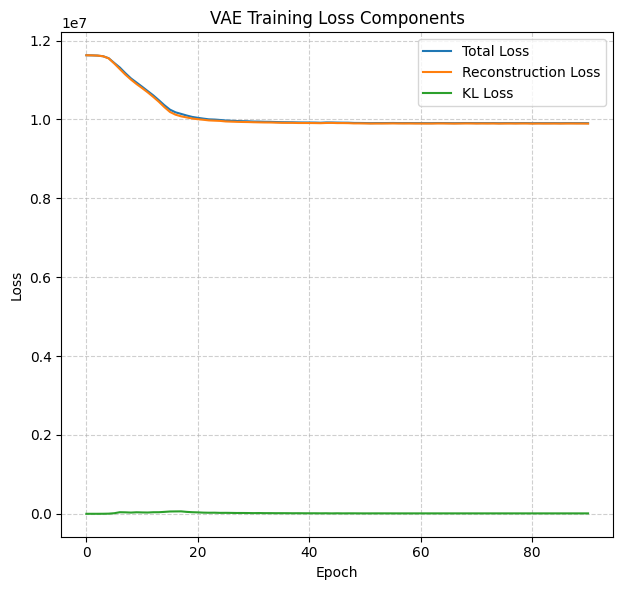

In [5]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Eğitimi başlat
epochs = 100
batch_size = 16

# Modeli eğit
history = vae.fit(
    X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, X_val),  # y_val olarak aynı veriyi verelim
    callbacks=[early_stopping, reduce_lr]
)

# Eğitim geçmişini görselleştir
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('VAE Training Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Validate loss da varsa ekleyin
if 'val_loss' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step
Optimal Threshold: 0.1624
F1 Score: 0.6944
ROC AUC: 0.6990


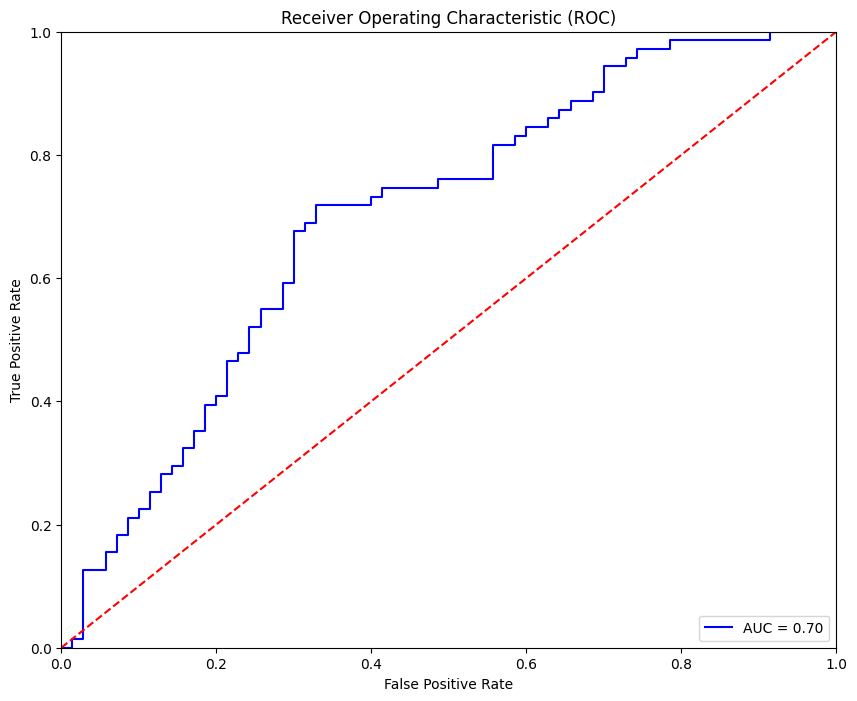

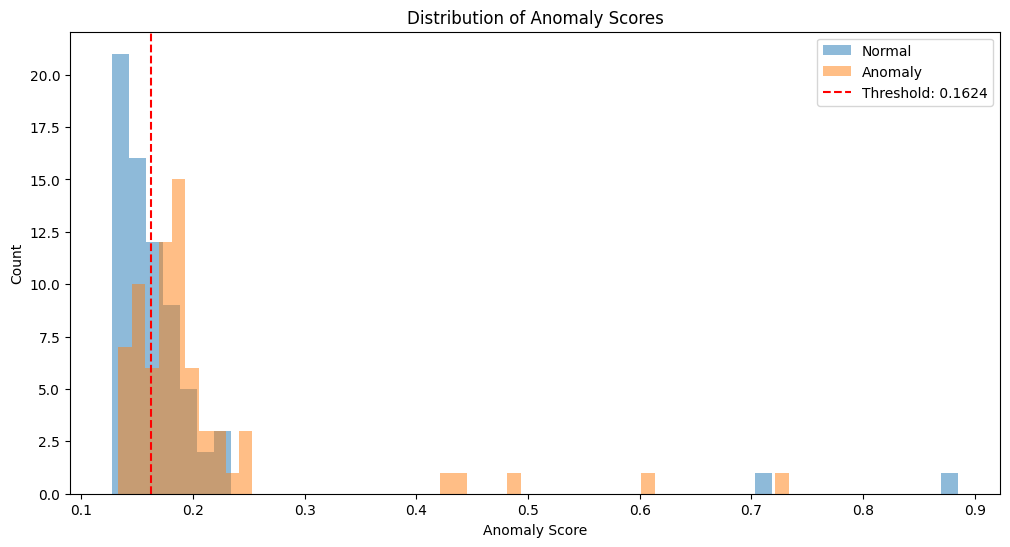

In [6]:
# VAE için anomali skoru hesaplama fonksiyonu
def compute_vae_anomaly_score(original_images, encoder, decoder):
    # Encoder çıktılarını al (ortalama, log-varyans, z)
    z_mean, z_log_var, z = encoder.predict(original_images)

    # Rekonstrüksiyonları al
    reconstructed_images = decoder.predict(z)

    # Rekonstrüksiyon hatası (MSE)
    mse_loss = np.mean(np.square(original_images - reconstructed_images), axis=(1, 2, 3))

    # KL Divergence bileşeni
    kl_loss = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=1)

    # Anomali skoru (ağırlıklı kombine skor)
    alpha = 0.8  # Rekonstrüksiyon hatasının ağırlığı
    beta = 0.2   # KL kaybının ağırlığı

    # Her iki bileşeni normalize et
    mse_loss = (mse_loss - np.min(mse_loss)) / (np.max(mse_loss) - np.min(mse_loss) + 1e-10)
    kl_loss = (kl_loss - np.min(kl_loss)) / (np.max(kl_loss) - np.min(kl_loss) + 1e-10)

    # Ağırlıklı anomali skoru
    anomaly_scores = alpha * mse_loss + beta * kl_loss

    return anomaly_scores, reconstructed_images

# Test verisi üzerinde anomali skorlarını hesapla
anomaly_scores, reconstructed_imgs = compute_vae_anomaly_score(test_all, encoder, decoder)

# ROC eğrisi hesaplama ve optimal eşik tespiti
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# Optimal eşik (Youden indeksi)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Tahmin etiketleri
pred_labels = (anomaly_scores > optimal_threshold).astype(int)

# F1 skoru
f1 = f1_score(true_labels, pred_labels)

# Sonuçları yazdır
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ROC eğrisi çizimi
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Normal/Anormal örneklerin skor dağılımı
plt.figure(figsize=(12, 6))
plt.hist(anomaly_scores[true_labels==0], bins=50, alpha=0.5, label='Normal')
plt.hist(anomaly_scores[true_labels==1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Threshold: {optimal_threshold:.4f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.show()

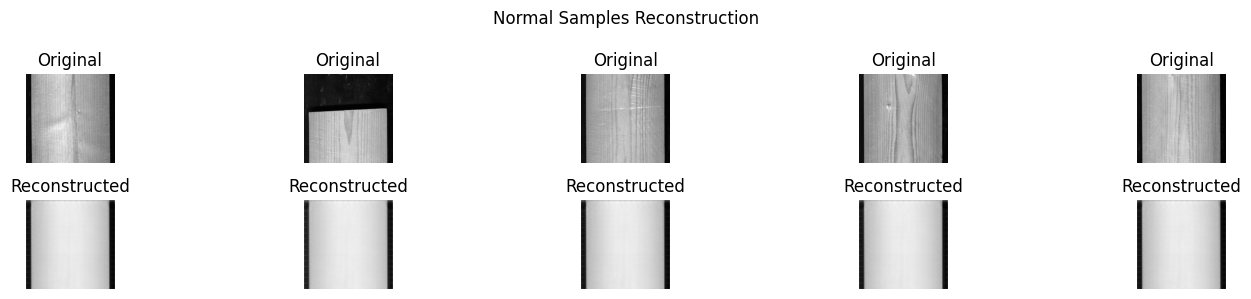

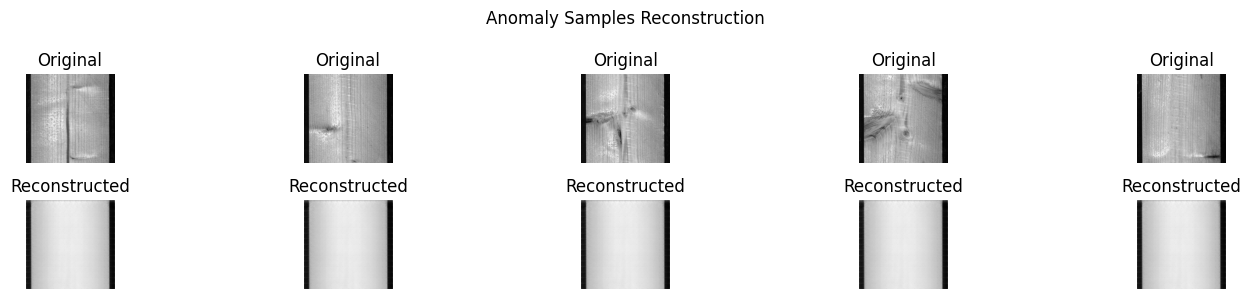

In [7]:
# Rekonstrüksiyonları görselleştirme
def plot_reconstructions(original_images, reconstructed_images, n=5, title=""):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        # Orijinal
        plt.subplot(2, n, i+1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Rekonstrüksiyon
        plt.subplot(2, n, n+i+1)
        plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Normal örneklerin rekonstrüksiyonları
normal_indices = np.where(true_labels == 0)[0][:5]
plot_reconstructions(
    test_all[normal_indices],
    reconstructed_imgs[normal_indices],
    n=5,
    title="Normal Samples Reconstruction"
)

# Anomalilerin rekonstrüksiyonları
anomaly_indices = np.where(true_labels == 1)[0][:5]
plot_reconstructions(
    test_all[anomaly_indices],
    reconstructed_imgs[anomaly_indices],
    n=5,
    title="Anomaly Samples Reconstruction"
)

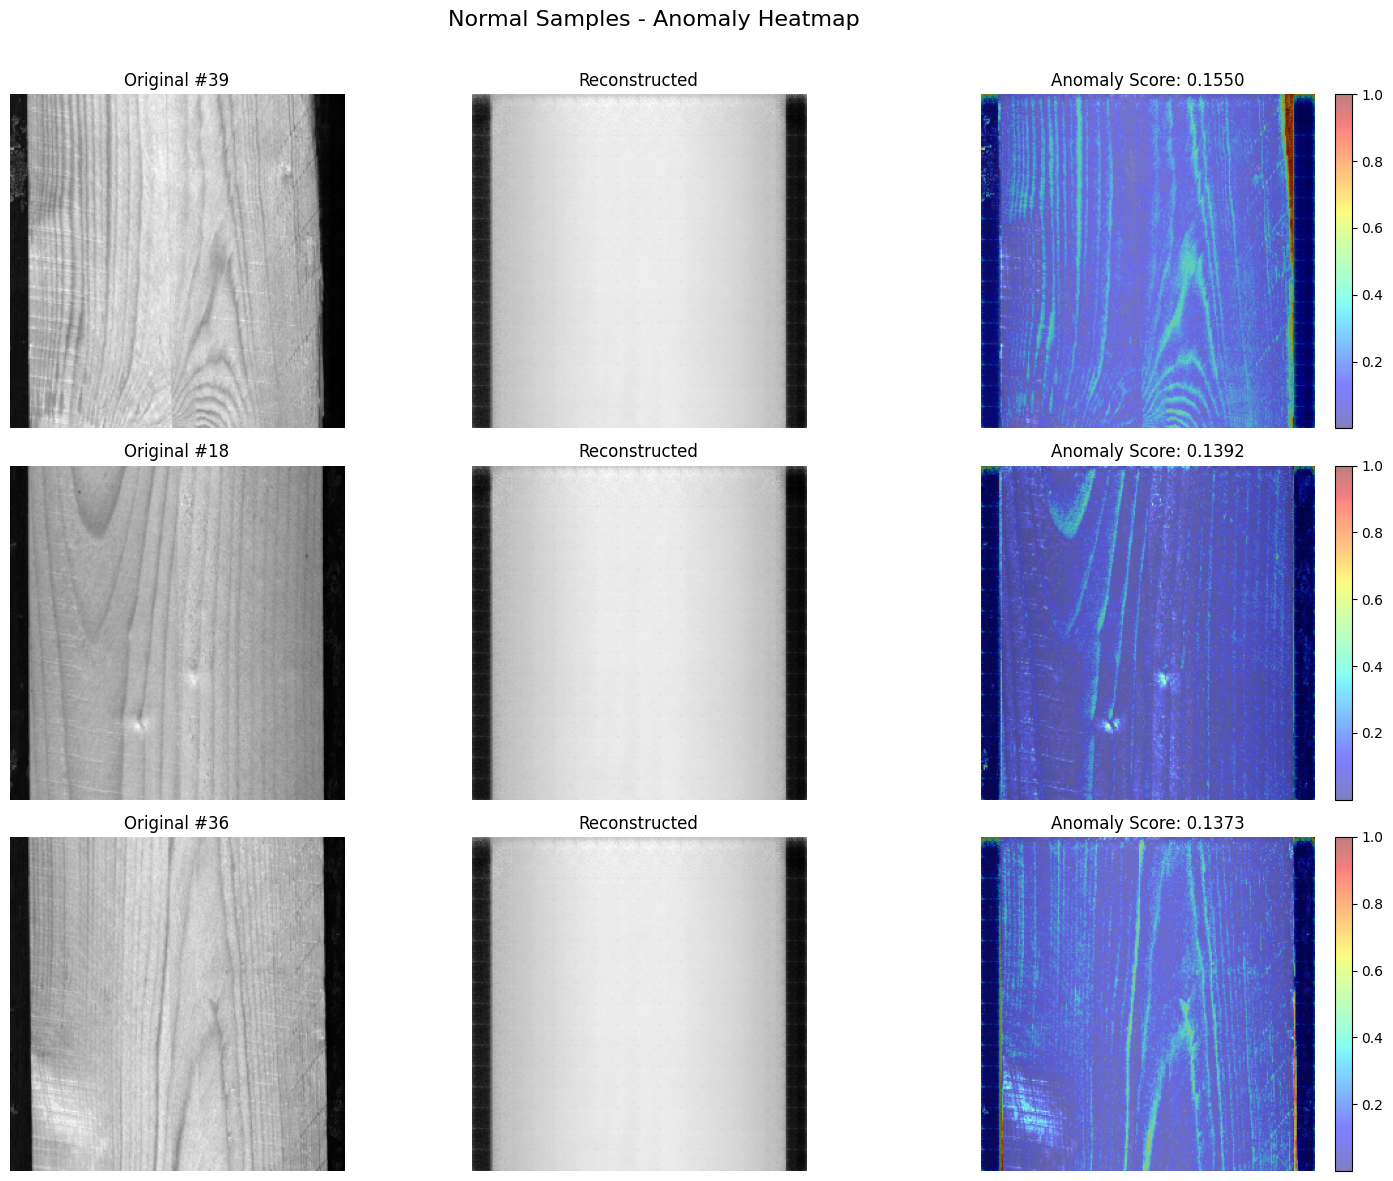

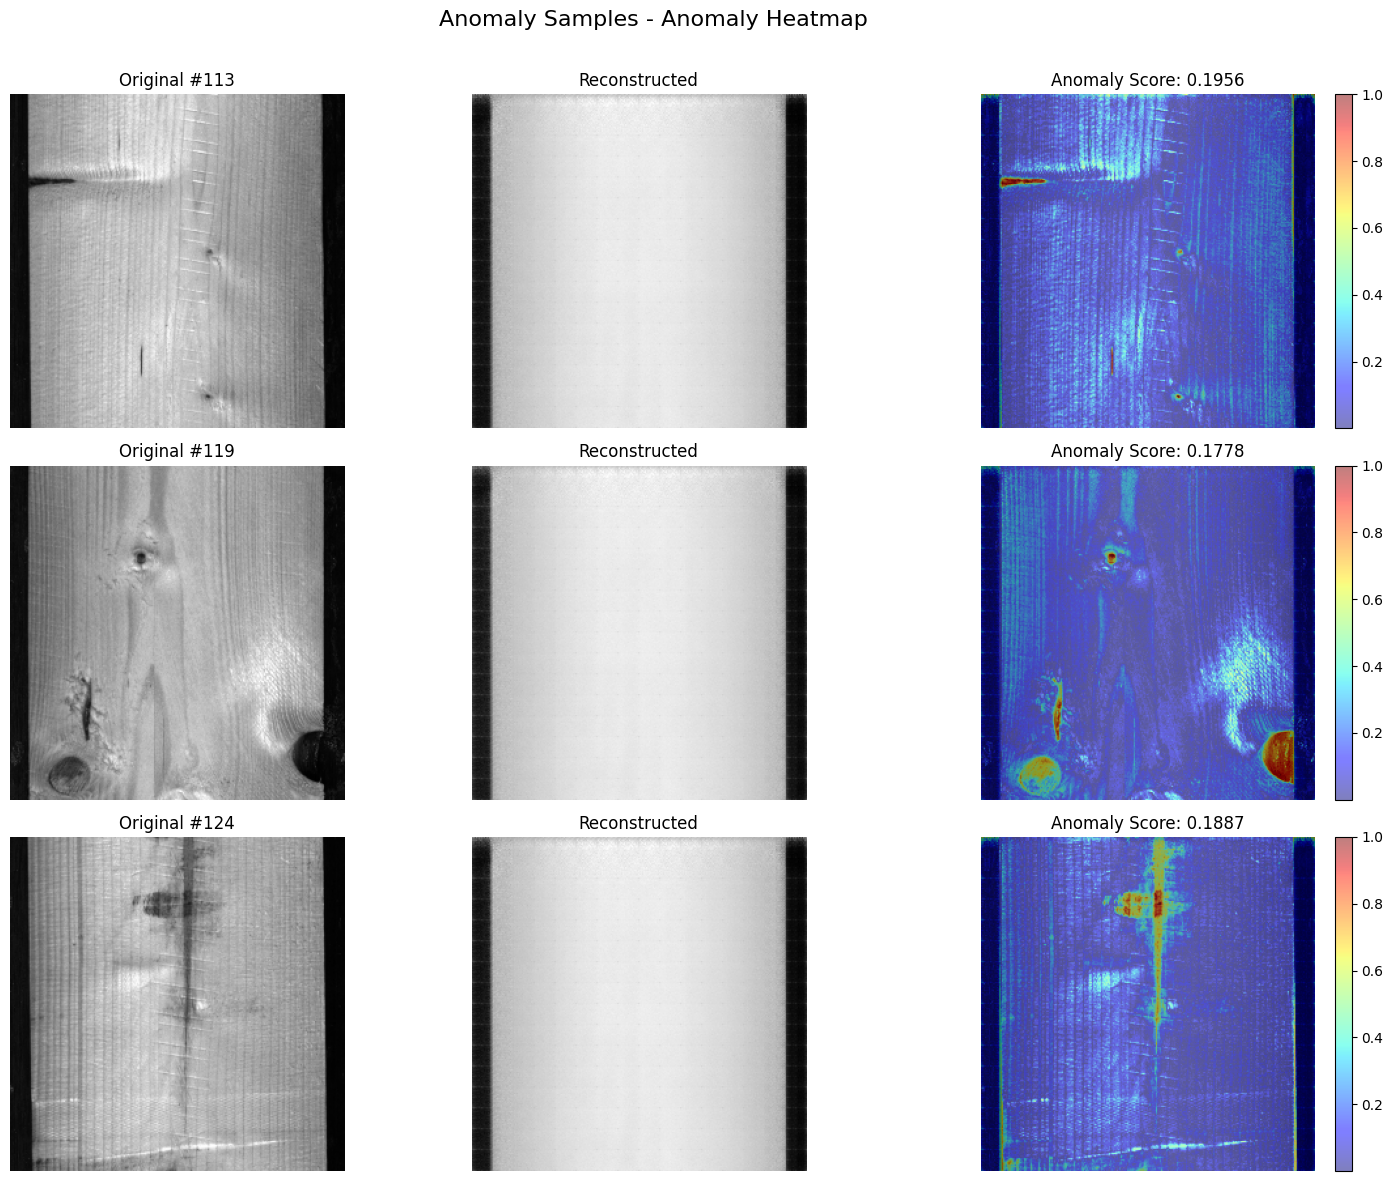

In [8]:
# Heatmap görselleştirme
def visualize_anomaly_heatmap(original_images, reconstructed_images, scores, indices, title=""):
    plt.figure(figsize=(15, 4*len(indices)))

    for i, idx in enumerate(indices):
        original = original_images[idx]
        reconstructed = reconstructed_images[idx]

        # Piksel bazında fark
        diff = np.abs(original - reconstructed)

        # Değerleri normalize et (daha iyi görselleştirme için)
        diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

        # Orijinal görüntü
        plt.subplot(len(indices), 3, 3*i+1)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.title(f'Original #{idx}')
        plt.axis('off')

        # Rekonstrüksiyon
        plt.subplot(len(indices), 3, 3*i+2)
        plt.imshow(reconstructed.squeeze(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

        # Heatmap
        plt.subplot(len(indices), 3, 3*i+3)
        plt.imshow(original.squeeze(), cmap='gray')
        heatmap = plt.imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.5)
        plt.colorbar(heatmap, fraction=0.046, pad=0.04)
        plt.title(f'Anomaly Score: {scores[idx]:.4f}')
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Rastgele normal ve anomali örnekleri seç
random_normal_indices = np.random.choice(np.where(true_labels == 0)[0], size=3, replace=False)
random_anomaly_indices = np.random.choice(np.where(true_labels == 1)[0], size=3, replace=False)

# Normal örnekleri görselleştir
visualize_anomaly_heatmap(
    test_all,
    reconstructed_imgs,
    anomaly_scores,
    random_normal_indices,
    title="Normal Samples - Anomaly Heatmap"
)

# Anomali örnekleri görselleştir
visualize_anomaly_heatmap(
    test_all,
    reconstructed_imgs,
    anomaly_scores,
    random_anomaly_indices,
    title="Anomaly Samples - Anomaly Heatmap"
)

Mean IoU: 0.0879


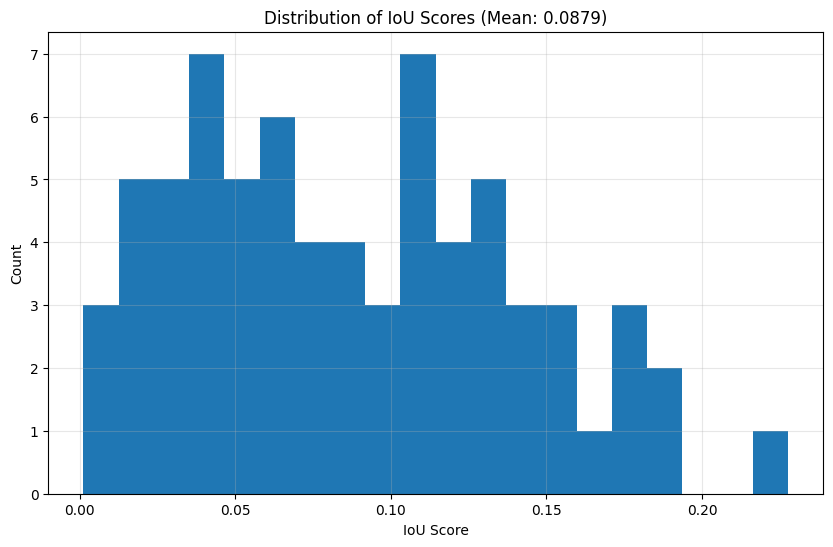

In [9]:
# Segmentasyon maskesi oluşturma
def generate_segmentation_masks(original_images, reconstructed_images, pixel_threshold=0.1):
    diff = np.abs(original_images - reconstructed_images)
    # Piksel-seviyesinde anomali maskesi
    masks = (diff > pixel_threshold).astype(np.uint8)
    return masks

# IoU hesaplama
def compute_iou(test_defect_images, reconstructed_defect_images, ground_truth_masks, pixel_threshold=0.1):
    # Segmentasyon maskelerini oluştur
    pred_masks = generate_segmentation_masks(test_defect_images, reconstructed_defect_images, pixel_threshold)

    ious = []
    for i in range(len(test_defect_images)):
        if i < len(ground_truth_masks):
            pred_mask = pred_masks[i].squeeze()
            gt_mask = (ground_truth_masks[i] > 0.1).astype(np.uint8).squeeze()

            # IoU hesapla (Jaccard endeksi)
            intersection = np.logical_and(gt_mask, pred_mask).sum()
            union = np.logical_or(gt_mask, pred_mask).sum()
            iou = intersection / union if union > 0 else 0
            ious.append(iou)

    return np.array(ious)

# Test defect görsellerinin rekonstrüksiyonları
test_defect_recon = reconstructed_imgs[len(test_good):]

# IoU hesapla
iou_scores = compute_iou(test_defect, test_defect_recon, mask_defect)
mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")

# IoU değerlerinin dağılımını görselleştir
plt.figure(figsize=(10, 6))
plt.hist(iou_scores, bins=20)
plt.xlabel('IoU Score')
plt.ylabel('Count')
plt.title(f'Distribution of IoU Scores (Mean: {mean_iou:.4f})')
plt.grid(True, alpha=0.3)
plt.show()

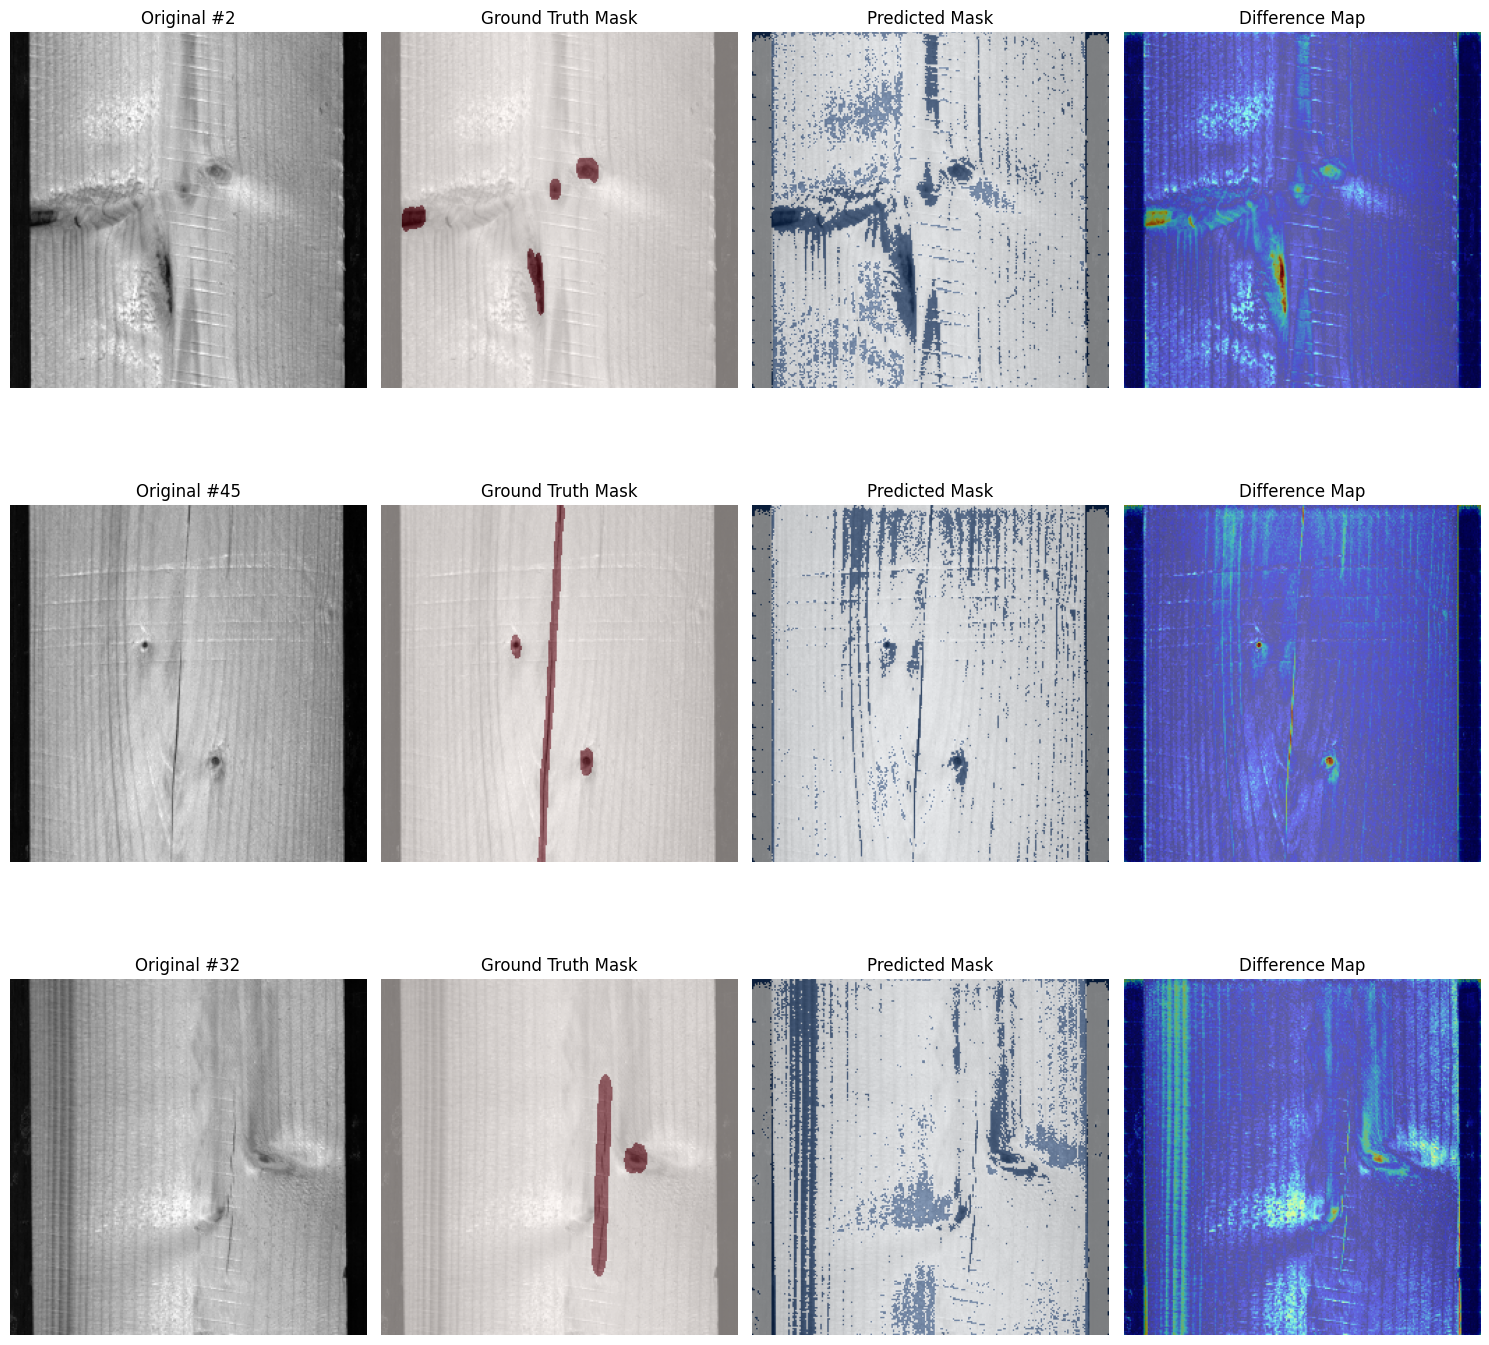

In [10]:
# Segmentasyon sonuçlarını görselleştirme
def visualize_segmentation(test_images, reconstructed_images, ground_truth, num_samples=3, pixel_threshold=0.1):
    # Rastgele örnekleri seç
    indices = np.random.choice(min(len(test_images), len(ground_truth)), size=num_samples, replace=False)

    # Segmentasyon maskeleri
    diff = np.abs(test_images - reconstructed_images)
    pred_masks = (diff > pixel_threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5*num_samples))
    for i, idx in enumerate(indices):
        # Orijinal görüntü
        plt.subplot(num_samples, 4, i*4+1)
        plt.imshow(test_images[idx].squeeze(), cmap='gray')
        plt.title(f'Original #{idx}')
        plt.axis('off')

        # Gerçek segmentasyon maskesi
        plt.subplot(num_samples, 4, i*4+2)
        plt.imshow(test_images[idx].squeeze(), cmap='gray')
        gt_mask = (ground_truth[idx] > 0.1).astype(np.uint8).squeeze()
        plt.imshow(gt_mask, cmap='Reds', alpha=0.5)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Tahmin edilen segmentasyon maskesi
        plt.subplot(num_samples, 4, i*4+3)
        plt.imshow(test_images[idx].squeeze(), cmap='gray')
        plt.imshow(pred_masks[idx].squeeze(), cmap='Blues', alpha=0.5)
        plt.title('Predicted Mask')
        plt.axis('off')

        # Fark haritası
        plt.subplot(num_samples, 4, i*4+4)
        diff_normalized = diff[idx] / np.max(diff[idx]) if np.max(diff[idx]) > 0 else diff[idx]
        plt.imshow(test_images[idx].squeeze(), cmap='gray')
        plt.imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.5)
        plt.title('Difference Map')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Sadece defect test görüntüleri için segmentasyon görselleştirme
visualize_segmentation(test_defect, test_defect_recon, mask_defect, num_samples=3)

In [11]:
# 1. Encoder ve Decoder modellerini ayrı ayrı kaydet
try:
    # Model yolları
    encoder_path = '/content/drive/MyDrive/wood_dataset/vae_encoder.h5'
    decoder_path = '/content/drive/MyDrive/wood_dataset/vae_decoder.h5'

    # Modelleri kaydet
    encoder.save(encoder_path)
    decoder.save(decoder_path)
    print(f"Encoder başarıyla kaydedildi: {encoder_path}")
    print(f"Decoder başarıyla kaydedildi: {decoder_path}")

    # 2. Sonuçları ve hiperparametreleri kaydet
    results_path = '/content/drive/MyDrive/wood_dataset/vae_results.npz'
    np.savez(
        results_path,
        auc=roc_auc,
        f1=f1,
        iou=mean_iou,
        threshold=optimal_threshold,
        scores=anomaly_scores,
        true_labels=true_labels,
        latent_dim=latent_dim,
        beta=1.0  # Kullandığınız beta değerini ekleyin
    )
    print(f"Sonuçlar başarıyla kaydedildi: {results_path}")

except Exception as e:
    print(f"Model kaydedilirken hata oluştu: {e}")

    # Alternatif kaydetme yöntemi (sadece ağırlıklar)
    weights_path = '/content/drive/MyDrive/wood_dataset/vae_weights'
    encoder.save_weights(f"{weights_path}_encoder.h5")
    decoder.save_weights(f"{weights_path}_decoder.h5")
    print(f"Model ağırlıkları başarıyla kaydedildi: {weights_path}")

Encoder başarıyla kaydedildi: /content/drive/MyDrive/wood_dataset/vae_encoder.h5
Decoder başarıyla kaydedildi: /content/drive/MyDrive/wood_dataset/vae_decoder.h5
Sonuçlar başarıyla kaydedildi: /content/drive/MyDrive/wood_dataset/vae_results.npz


In [12]:
# Kaydedilmiş modelleri yükleme
#from tensorflow.keras.models import load_model

# Encoder ve decoder'ı yükle
#encoder = load_model('/content/drive/MyDrive/wood_dataset/vae_encoder.h5')
#decoder = load_model('/content/drive/MyDrive/wood_dataset/vae_decoder.h5')

# Sonuçları yükle
#results = np.load('/content/drive/MyDrive/wood_dataset/vae_results.npz')
#optimal_threshold = results['threshold']
#f1 = results['f1']
#auc = results['auc']

#print(f"Modeller başarıyla yüklendi. F1: {f1}, AUC: {auc}")

# Yeni görüntülerde tahmin yapmak için:
#def predict_anomaly(image_path, encoder, decoder, threshold):
    # Görüntüyü yükle ve ön işleme
#    img = load_img(image_path, target_size=(256, 256), color_mode='grayscale')
#    img = img_to_array(img) / 255.0
#    img = np.expand_dims(img, axis=0)

    # Anomali skoru hesapla
#    z_mean, z_log_var, z = encoder.predict(img)
#    reconstructed = decoder.predict(z)

    # Rekonstrüksiyon hatası
#    mse_loss = np.mean(np.square(img - reconstructed))

    # KL kaybı
#    kl_loss = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))

    # Anomali skoru
#    anomaly_score = 0.8 * mse_loss + 0.2 * kl_loss

    # Tahmin
#    is_anomaly = anomaly_score > threshold

#    return is_anomaly, anomaly_score, reconstructed

In [13]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

def create_vae_report(encoder, decoder, test_all, true_labels, anomaly_scores,
                      reconstructed_imgs, optimal_threshold, f1, roc_auc, fpr, tpr,
                      test_good, test_defect, mask_defect=None, mean_iou=None):
    """
    Creates a comprehensive HTML report for VAE anomaly detection results

    Args:
        encoder: Trained encoder model
        decoder: Trained decoder model
        test_all: Combined test images (good + defect)
        true_labels: Binary ground truth labels (0: normal, 1: anomaly)
        anomaly_scores: Computed anomaly scores for test images
        reconstructed_imgs: Reconstructed test images
        optimal_threshold: Optimal threshold for anomaly detection
        f1: F1 score
        roc_auc: Area under ROC curve
        fpr: False positive rates for ROC curve
        tpr: True positive rates for ROC curve
        test_good: Normal test images
        test_defect: Defect test images
        mask_defect: Ground truth defect masks (optional)
        mean_iou: Mean IoU for segmentation (optional)

    Returns:
        HTML content as a string
    """
    # Get predictions based on optimal threshold
    predictions = (anomaly_scores > optimal_threshold).astype(int)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Image_Index': range(len(test_all)),
        'True_Label': ['Good' if label == 0 else 'Defect' for label in true_labels],
        'Predicted_Label': ['Good' if pred == 0 else 'Defect' for pred in predictions],
        'Anomaly_Score': anomaly_scores,
        'Is_Correct': true_labels == predictions
    })

    # Calculate performance metrics
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions,
                                         target_names=['Good', 'Defect'],
                                         output_dict=True)

    # Generate confusion matrix figure
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good', 'Defect'],
                yticklabels=['Good', 'Defect'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Save confusion matrix to bytes for embedding in HTML
    conf_matrix_img = BytesIO()
    plt.tight_layout()
    plt.savefig(conf_matrix_img, format='png')
    plt.close()
    conf_matrix_b64 = base64.b64encode(conf_matrix_img.getvalue()).decode('utf-8')

    # Generate ROC curve figure
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Save ROC curve to bytes for embedding in HTML
    roc_img = BytesIO()
    plt.tight_layout()
    plt.savefig(roc_img, format='png')
    plt.close()
    roc_img_b64 = base64.b64encode(roc_img.getvalue()).decode('utf-8')

    # Generate score distribution figure
    plt.figure(figsize=(10, 6))
    sns.histplot(anomaly_scores[true_labels==0], bins=30, alpha=0.5, label='Normal')
    sns.histplot(anomaly_scores[true_labels==1], bins=30, alpha=0.5, label='Anomaly')
    plt.axvline(x=optimal_threshold, color='r', linestyle='--',
                label=f'Threshold: {optimal_threshold:.4f}')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Count')
    plt.title('Distribution of Anomaly Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save distribution figure to bytes for embedding in HTML
    dist_img = BytesIO()
    plt.tight_layout()
    plt.savefig(dist_img, format='png')
    plt.close()
    dist_img_b64 = base64.b64encode(dist_img.getvalue()).decode('utf-8')

    # Generate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels, anomaly_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'F1-Score = {f1:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save PR curve to bytes for embedding in HTML
    pr_img = BytesIO()
    plt.tight_layout()
    plt.savefig(pr_img, format='png')
    plt.close()
    pr_img_b64 = base64.b64encode(pr_img.getvalue()).decode('utf-8')

    # Example visualizations
    example_images = []

    # Generate reconstruction examples for normal samples
    num_normal_examples = min(3, len(test_good))
    for i in range(num_normal_examples):
        idx = i  # Index in test_good
        global_idx = i  # Index in test_all

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Original image
        original = test_all[global_idx]
        reconstructed = reconstructed_imgs[global_idx]

        # Calculate difference and normalize for visualization
        diff = np.abs(original - reconstructed)
        diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

        # Original
        axes[0].imshow(original.squeeze(), cmap='gray')
        axes[0].set_title(f'Original (Normal)')
        axes[0].axis('off')

        # Reconstruction
        axes[1].imshow(reconstructed.squeeze(), cmap='gray')
        axes[1].set_title('Reconstructed')
        axes[1].axis('off')

        # Heatmap overlay
        axes[2].imshow(original.squeeze(), cmap='gray')
        heatmap = axes[2].imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.5)
        axes[2].set_title(f'Anomaly Score: {anomaly_scores[global_idx]:.4f}')
        axes[2].axis('off')
        fig.colorbar(heatmap, ax=axes[2], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        example_images.append({
            'image': img_b64,
            'index': global_idx,
            'true_class': 'Good',
            'pred_class': 'Good' if predictions[global_idx] == 0 else 'Defect',
            'is_correct': predictions[global_idx] == 0,
            'score': anomaly_scores[global_idx]
        })

    # Generate reconstruction examples for anomaly samples
    num_anomaly_examples = min(3, len(test_defect))
    for i in range(num_anomaly_examples):
        idx = i  # Index in test_defect
        global_idx = i + len(test_good)  # Index in test_all

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Original image
        original = test_all[global_idx]
        reconstructed = reconstructed_imgs[global_idx]

        # Calculate difference and normalize for visualization
        diff = np.abs(original - reconstructed)
        diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

        # Original
        axes[0].imshow(original.squeeze(), cmap='gray')
        axes[0].set_title(f'Original (Defect)')
        axes[0].axis('off')

        # Reconstruction
        axes[1].imshow(reconstructed.squeeze(), cmap='gray')
        axes[1].set_title('Reconstructed')
        axes[1].axis('off')

        # Heatmap overlay
        axes[2].imshow(original.squeeze(), cmap='gray')
        heatmap = axes[2].imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.5)
        axes[2].set_title(f'Anomaly Score: {anomaly_scores[global_idx]:.4f}')
        axes[2].axis('off')
        fig.colorbar(heatmap, ax=axes[2], fraction=0.046, pad=0.04)

        plt.tight_layout()

        img_bytes = BytesIO()
        plt.savefig(img_bytes, format='png')
        plt.close(fig)
        img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

        example_images.append({
            'image': img_b64,
            'index': global_idx,
            'true_class': 'Defect',
            'pred_class': 'Good' if predictions[global_idx] == 0 else 'Defect',
            'is_correct': predictions[global_idx] == 1,
            'score': anomaly_scores[global_idx]
        })

    # Segmentation examples
    segmentation_examples = []

    if mask_defect is not None and len(mask_defect) > 0:
        # Generate segmentation masks
        pixel_threshold = 0.1  # Adjust as needed

        # Use only defect test images and their reconstructions
        defect_start_idx = len(test_good)
        test_defect_recon = reconstructed_imgs[defect_start_idx:]

        # Loop through a few defect examples
        for i in range(min(3, len(test_defect), len(mask_defect))):
            fig, axes = plt.subplots(1, 4, figsize=(18, 4))

            # Original image
            original = test_defect[i]
            reconstructed = test_defect_recon[i]

            # Calculate difference
            diff = np.abs(original - reconstructed)
            diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

            # Create binary mask using threshold
            pred_mask = (diff > pixel_threshold).astype(np.uint8)
            gt_mask = (mask_defect[i] > 0.1).astype(np.uint8)

            # Calculate IoU for this sample
            intersection = np.logical_and(gt_mask.squeeze(), pred_mask.squeeze()).sum()
            union = np.logical_or(gt_mask.squeeze(), pred_mask.squeeze()).sum()
            iou = intersection / union if union > 0 else 0

            # Original image
            axes[0].imshow(original.squeeze(), cmap='gray')
            axes[0].set_title(f'Original (Defect #{i})')
            axes[0].axis('off')

            # Ground truth mask
            axes[1].imshow(original.squeeze(), cmap='gray')
            axes[1].imshow(gt_mask.squeeze(), cmap='Reds', alpha=0.5)
            axes[1].set_title('Ground Truth Mask')
            axes[1].axis('off')

            # Predicted mask
            axes[2].imshow(original.squeeze(), cmap='gray')
            axes[2].imshow(pred_mask.squeeze(), cmap='Blues', alpha=0.5)
            axes[2].set_title(f'Predicted Mask (IoU: {iou:.4f})')
            axes[2].axis('off')

            # Difference heatmap
            axes[3].imshow(original.squeeze(), cmap='gray')
            heatmap = axes[3].imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.5)
            axes[3].set_title('Reconstruction Difference')
            axes[3].axis('off')
            fig.colorbar(heatmap, ax=axes[3], fraction=0.046, pad=0.04)

            plt.tight_layout()

            img_bytes = BytesIO()
            plt.savefig(img_bytes, format='png')
            plt.close(fig)
            img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

            segmentation_examples.append({
                'image': img_b64,
                'index': i,
                'iou': iou
            })

    # Create HTML content
    html_content = f'''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Wood Defect Detection - VAE Results</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .header {{ text-align: center; margin-bottom: 30px; }}
            .metrics {{ display: flex; justify-content: space-around; margin-bottom: 30px; flex-wrap: wrap; }}
            .metric-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; width: 200px; text-align: center; margin: 10px; }}
            .chart-container {{ margin-bottom: 30px; }}
            .results-table {{ width: 100%; border-collapse: collapse; margin-bottom: 30px; }}
            .results-table th, .results-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            .results-table th {{ background-color: #f2f2f2; }}
            .example-container {{ margin-bottom: 40px; }}
            .example-item {{ margin-bottom: 20px; }}
            .correct {{ color: green; }}
            .incorrect {{ color: red; }}
            .model-details {{ margin-bottom: 20px; background-color: #f9f9f9; padding: 15px; border-radius: 8px; }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Wood Defect Detection Report (VAE Model)</h1>
                <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>

            <div class="model-details">
                <h2>Model Architecture</h2>
                <p>Variational Autoencoder (VAE) with latent dimension: {latent_dim}</p>
                <p>Encoder: Custom CNN architecture with Leaky ReLU activations</p>
                <p>Decoder: Transpose convolutions with sigmoid output activation</p>
                <p>Anomaly score: Weighted combination of reconstruction error and KL divergence</p>
            </div>

            <h2>Performance Summary</h2>
            <div class="metrics">
                <div class="metric-card">
                    <h3>Accuracy</h3>
                    <p>{(true_labels == predictions).mean():.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>F1 Score</h3>
                    <p>{f1:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>ROC AUC</h3>
                    <p>{roc_auc:.4f}</p>
                </div>
                <div class="metric-card">
                    <h3>Optimal Threshold</h3>
                    <p>{optimal_threshold:.4f}</p>
                </div>
    '''

    # Add IoU metric if available
    if mean_iou is not None:
        html_content += f'''
                <div class="metric-card">
                    <h3>Mean IoU</h3>
                    <p>{mean_iou:.4f}</p>
                </div>
        '''

    html_content += f'''
            </div>

            <div class="chart-container">
                <h2>Confusion Matrix</h2>
                <img src="data:image/png;base64,{conf_matrix_b64}" alt="Confusion Matrix" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>ROC Curve</h2>
                <img src="data:image/png;base64,{roc_img_b64}" alt="ROC Curve" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>Precision-Recall Curve</h2>
                <img src="data:image/png;base64,{pr_img_b64}" alt="Precision-Recall Curve" style="max-width:100%;">
            </div>

            <div class="chart-container">
                <h2>Anomaly Score Distribution</h2>
                <img src="data:image/png;base64,{dist_img_b64}" alt="Score Distribution" style="max-width:100%;">
            </div>

            <h2>Classification Results</h2>
            <table class="results-table">
                <tr>
                    <th>Class</th>
                    <th>Precision</th>
                    <th>Recall</th>
                    <th>F1-Score</th>
                    <th>Support</th>
                </tr>
                <tr>
                    <td>Good</td>
                    <td>{class_report['Good']['precision']:.4f}</td>
                    <td>{class_report['Good']['recall']:.4f}</td>
                    <td>{class_report['Good']['f1-score']:.4f}</td>
                    <td>{class_report['Good']['support']}</td>
                </tr>
                <tr>
                    <td>Defect</td>
                    <td>{class_report['Defect']['precision']:.4f}</td>
                    <td>{class_report['Defect']['recall']:.4f}</td>
                    <td>{class_report['Defect']['f1-score']:.4f}</td>
                    <td>{class_report['Defect']['support']}</td>
                </tr>
            </table>

            <h2>Reconstruction Examples</h2>
            <div class="example-container">
    '''

    # Add reconstruction examples to HTML
    # Add reconstruction examples to HTML
    for example in example_images:
        correct_class = 'correct' if example['is_correct'] else 'incorrect'
        html_content += f'''
                <div class="example-item">
                    <h3>Image #{example['index']} -
                        <span>True: {example['true_class']}, </span>
                        <span class="{correct_class}">Predicted: {example['pred_class']}</span>
                        <span>(Score: {example['score']:.4f})</span>
                    </h3>
                    <img src="data:image/png;base64,{example['image']}" alt="Example" style="max-width:100%;">
                </div>
        '''

    html_content += '''
            </div>
    '''

    # Add segmentation examples if available
    if segmentation_examples:
        html_content += '''
            <h2>Segmentation Examples</h2>
            <div class="example-container">
        '''

        for example in segmentation_examples:
            html_content += f'''
                <div class="example-item">
                    <h3>Defect Image #{example['index']} -
                        <span>IoU Score: {example['iou']:.4f}</span>
                    </h3>
                    <img src="data:image/png;base64,{example['image']}" alt="Segmentation Example" style="max-width:100%;">
                </div>
            '''

        html_content += '''
            </div>
        '''

    # Close the HTML document
    html_content += '''
        </div>
    </body>
    </html>
    '''

    return html_content

# Generate the HTML report
vae_html_report = create_vae_report(
    encoder=encoder,
    decoder=decoder,
    test_all=test_all,
    true_labels=true_labels,
    anomaly_scores=anomaly_scores,
    reconstructed_imgs=reconstructed_imgs,
    optimal_threshold=optimal_threshold,
    f1=f1,
    roc_auc=roc_auc,
    fpr=fpr,
    tpr=tpr,
    test_good=test_good,
    test_defect=test_defect,
    mask_defect=mask_defect,
    mean_iou=mean_iou
)

# Save the HTML report to file
report_path = os.path.join(DATASET_DIR, 'vae_report.html')
with open(report_path, 'w') as f:
    f.write(vae_html_report)

print(f"VAE model report saved to: {report_path}")

# Print a summary of the results
print("\nVAE Classification Summary:")
print(f"Total test samples: {len(test_all)}")
print(f"Normal samples: {len(test_good)}, Anomaly samples: {len(test_defect)}")
print(f"Accuracy: {(true_labels == pred_labels).mean():.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
if mean_iou is not None:
    print(f"Mean IoU: {mean_iou:.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")

VAE model report saved to: /content/drive/MyDrive/wood_dataset/wood/vae_report.html

VAE Classification Summary:
Total test samples: 141
Normal samples: 70, Anomaly samples: 71
Accuracy: 0.6879
F1 Score: 0.6944
ROC AUC: 0.6990
Mean IoU: 0.0879
Optimal threshold: 0.1624
